### Examine the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


# Read the dataset
df = pd.read_csv('waterTank_ctrl_stuckAt1.csv', index_col=0, header=0, parse_dates=True)
df.index.freq = 'MS'

df.head()


,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [2]:
df.isna().sum()

Tank1WaterLevel    0
Tank2WaterLevel    0
Tank1InFlow        0
Tank2OutFlow       0
wt3_valve          0
Tank3OutFlow       0
Tank2.level        0
dtype: int64

In [3]:
len(df)

15001

### Plot the source data

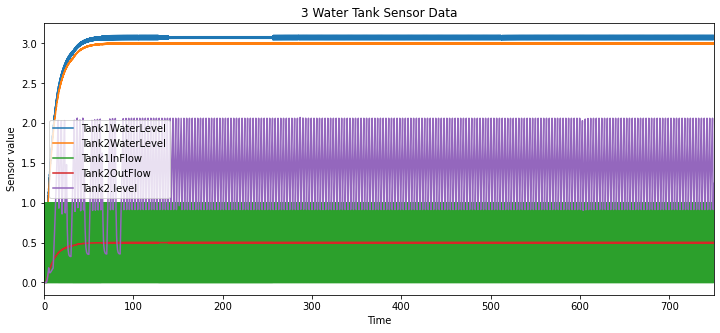

In [4]:
# ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
title = '3 Water Tank Sensor Data'
ylabel = 'Sensor value'
xlabel = ''
ax = df['Tank1WaterLevel'].plot(legend=True, title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['Tank2WaterLevel'].plot(legend=True)
df['Tank1InFlow'].plot(legend=True)
df['Tank2OutFlow'].plot(legend=True)
# df['wt3_valve'].plot(legend=True)
# df['Tank3OutFlow'].plot(legend=True)
df['Tank2.level'].plot(legend=True)
plt.show()

In [5]:
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    '''
    Hypothesis Test for Stationarity
    Pass in a time series and an optional title, return an ADF report
    '''
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [6]:
adf_test(df['Tank1WaterLevel'])

Augmented Dickey-Fuller Test: 
ADF test statistics    -1.325979e+01
p-value                 8.443583e-25
#lags                   4.200000e+01
#observations           1.495800e+04
critical value (1%)    -3.430787e+00
critical value (5%)    -2.861733e+00
critical value (10%)   -2.566873e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Take the first order difference of the entire dataframe and re-run the dickey fuller test

In [7]:
# All the correlated features are stationary.
df.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [8]:
len(df)

15001

In [9]:
# Train Test Split
nobs = 3000
train = df.iloc[:-nobs]
test = df.iloc[-nobs:]
len(train), len(test)

(12001, 3000)

### VAR Model Order Selection

In [10]:
p = [1,2,3,4,5,6,7] # try with list of 7 p values
p = list(range(1,20))
aic, bic = [], []
for i in p:
    model = VAR(train)
    results = model.fit(i)
    aic.append(results.aic)
    bic.append(results.bic)
    print(f'VAR Order {i}')
    print('AIC: {}'.format(results.aic))
    print('BIC: {}'.format(results.bic))
    print()

min_aic = min(aic)
min_aic_index = aic.index(min_aic) + 1
min_bic = min(bic)
min_bic_index = bic.index(min_bic) + 1
print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))


VAR Order 1
AIC: -60.22551040606579
BIC: -60.191011317064856

VAR Order 2
AIC: -65.5419646485788
BIC: -65.47727419502799

VAR Order 3
AIC: -68.71655140783908
BIC: -68.621665237792

VAR Order 4
AIC: -71.59475743641423
BIC: -71.46967119692138

VAR Order 5
AIC: -73.04490497475028
BIC: -72.88961431185874

VAR Order 6
AIC: -74.11025099040006
BIC: -73.92475154915309

VAR Order 7
AIC: -75.09790763912595
BIC: -74.88219506356275

VAR Order 8
AIC: -75.41409826922668
BIC: -75.16816820238206

VAR Order 9
AIC: -75.88840003518266
BIC: -75.61224811908671

VAR Order 10
AIC: -77.52912474075123
BIC: -77.22274661642902

VAR Order 11
AIC: -77.91095931648286
BIC: -77.5743506239541

VAR Order 12
AIC: -78.70211824981833
BIC: -78.33527462809708

VAR Order 13
AIC: -78.97831473426118
BIC: -78.58123182135552

VAR Order 14
AIC: -79.56621342369652
BIC: -79.13888685660822

VAR Order 15
AIC: -79.852775796529
BIC: -79.39520121125322

VAR Order 16
AIC: -80.3812141692982
BIC: -79.89338720082318

VAR Order 17
AIC: -81.1

In [11]:
# let's confirm that both the variables are included in the model
model.endog_names

['Tank1WaterLevel',
 'Tank2WaterLevel',
 'Tank1InFlow',
 'Tank2OutFlow',
 'wt3_valve',
 'Tank3OutFlow',
 'Tank2.level']

In [12]:
from IPython.display import Markdown as md
md("Fit the VAR( {{}} ) model".format(min_aic_index))

Fit the VAR( {} ) model

### Fit the VAR {{min_aic_index}}  model

In [13]:
min_aic_index

19

In [14]:
results = model.fit(min_aic_index)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Apr, 2023
Time:                     16:14:24
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -81.7157
Nobs:                     11982.0    HQIC:                  -82.1002
Log likelihood:           374951.    FPE:                1.81994e-36
AIC:                     -82.2943    Det(Omega_mle):     1.68364e-36
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.017650         0.002186            8.072           0.000
L1.Tank1WaterLevel          0.330971         0.010403           31.814           0.000
L1.Tank2WaterLevel        

### Predict the next 20 values

In [15]:
# For predictions, VAR model uses .forecast() instead of predictions.
lag_order = results.k_ar
lag_order

19

In [16]:
df.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [17]:
steps = 20
# z = results.forecast(y=train.values[-lag_order:], steps = 20)
z = results.forecast(y=train.values[-lag_order:], steps=steps)
z

array([[ 3.09252318e+00,  3.00415400e+00, -3.74119084e-04,
         5.00300356e-01,  1.00688493e+00,  2.21612190e+00,
         1.58099116e+00],
       [ 3.06257473e+00,  3.00403208e+00, -1.85129159e-03,
         5.00992094e-01,  1.00453926e+00,  2.09581433e+00,
         1.48164752e+00],
       [ 3.04800894e+00,  2.99866650e+00,  8.48860778e-03,
         5.00275523e-01,  1.00832692e+00,  2.00124111e+00,
         1.41952647e+00],
       [ 3.07884266e+00,  2.99454631e+00,  1.00145193e+00,
         4.98964596e-01,  1.00104665e+00,  1.89039459e+00,
         1.33316567e+00],
       [ 3.09522292e+00,  2.99832670e+00,  9.96616720e-01,
         4.99267030e-01,  1.00688879e+00,  1.79534812e+00,
         1.27929506e+00],
       [ 3.08100444e+00,  3.00565443e+00, -1.03335827e-03,
         5.00791199e-01,  1.00713167e+00,  1.70663543e+00,
         1.20438028e+00],
       [ 3.06234859e+00,  3.00401627e+00, -7.29958735e-03,
         5.00988666e-01,  1.00569562e+00,  1.63909352e+00,
         1.1570494

In [18]:
test

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
600.05,3.092560,3.004144,0,0.500300,1,2.215860,1.581144
600.10,3.062618,3.004037,0,0.500995,1,2.077500,1.482416
600.15,3.047931,2.998697,0,0.500285,1,1.991554,1.421088
600.20,3.078778,2.994546,1,0.498971,1,1.871290,1.335273
600.25,3.095067,2.998294,1,0.499269,1,1.796484,1.281895
...,...,...,...,...,...,...,...
749.80,3.092561,3.004145,0,0.500300,0,0.000000,1.141047
749.85,3.071222,3.005454,0,0.501029,0,0.000000,1.161055
749.90,3.047931,2.998697,0,0.500285,0,0.000000,1.191114


In [19]:
# idx = pd.date_range(start='1/1/2015', periods=12, freq='MS')
# df_forecast = pd.DataFrame(z, index=idx, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast = pd.DataFrame(z, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast[:5]

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
0,3.092523,3.004154,-0.000374,0.500300,1.006885,2.216122,1.580991
1,3.062575,3.004032,-0.001851,0.500992,1.004539,2.095814,1.481648
2,3.048009,2.998667,0.008489,0.500276,1.008327,2.001241,1.419526
3,3.078843,2.994546,1.001452,0.498965,1.001047,1.890395,1.333166
4,3.095223,2.998327,0.996617,0.499267,1.006889,1.795348,1.279295


### Plot the results

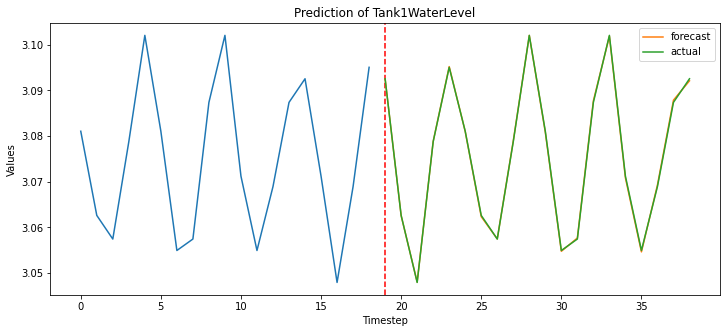

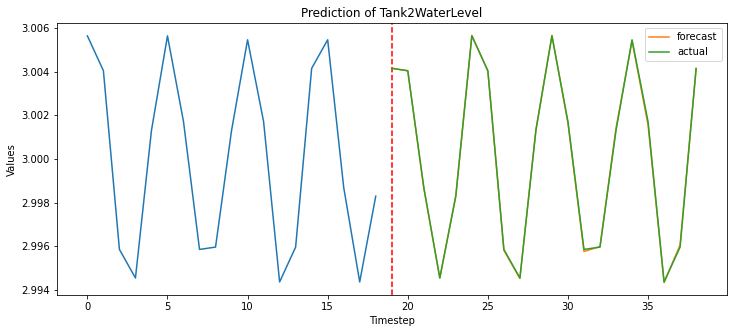

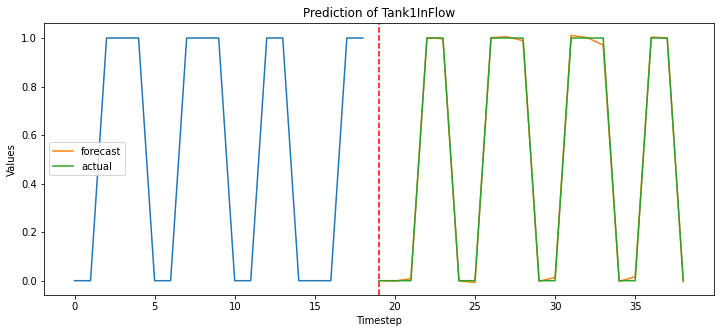

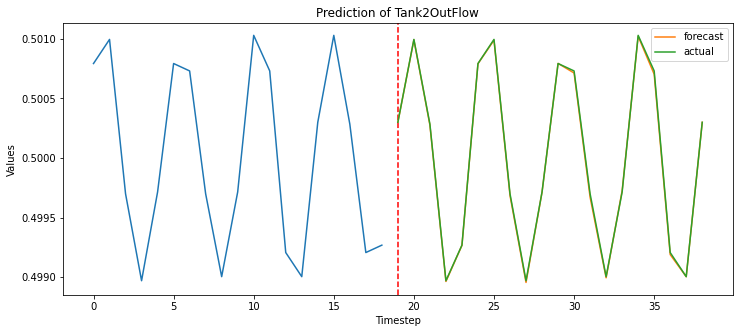

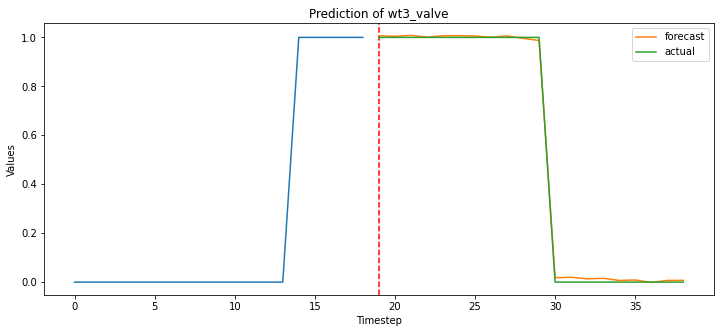

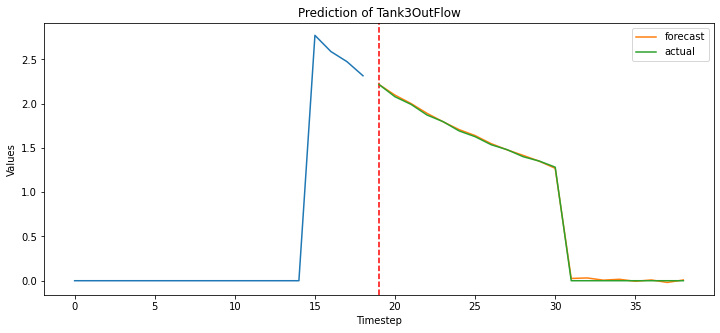

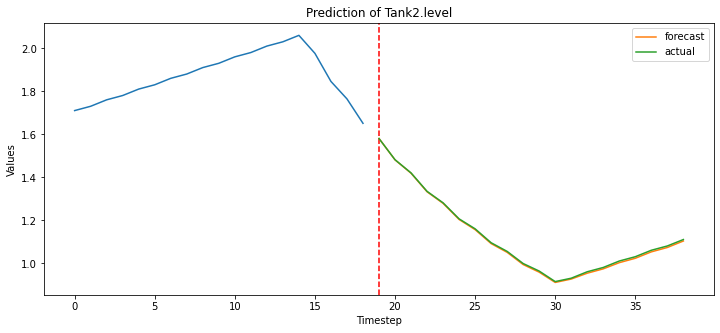

In [26]:
attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index = pd.Index(list(range(lag_order)))
    actual = train.iloc[-lag_order:,:]
    
    index = pd.Index(list(range(lag_order, lag_order + steps)))
    actual = actual.set_index(actual_index)
    pred = df_forecast.set_index(index)
    actual_test = test.iloc[:lag_order+1,:].set_index(index)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual.iloc[:,i])
    plt.plot(pred.iloc[:,i], label="forecast")
    plt.plot(actual_test.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

### Model Evaluation

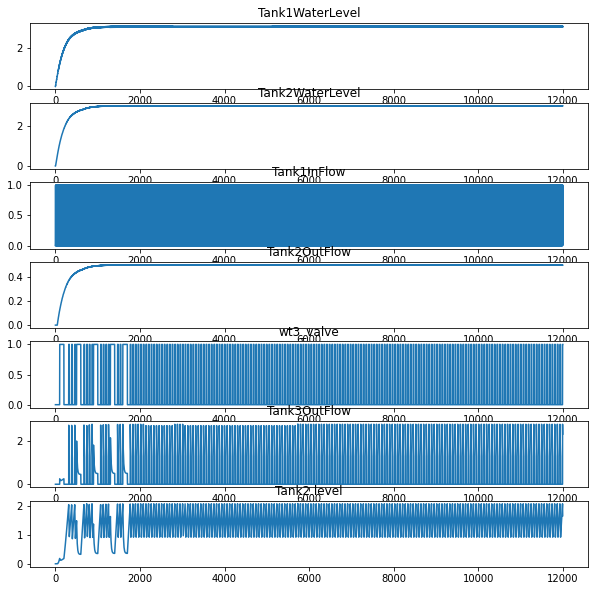

In [21]:
results.plot();

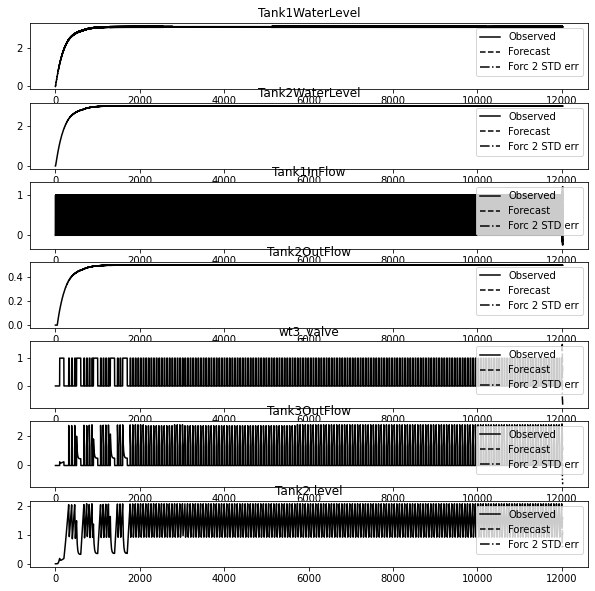

In [22]:
results.plot_forecast(20);

In [23]:
len(df_forecast)

20

In [24]:
len(df['Tank1WaterLevel'].iloc[:steps])

20

### Model Evaluation

In [25]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSE = []
for feat in attr:
    RMSE.append(rmse(df[feat].iloc[:steps], df_forecast[feat]))

print(RMSE)

[2.9536430161353318, 2.9092500982009653, 0.7370472109864065, 0.5000032034054207, 0.7437509712056911, 1.3365178760773049, 1.1447470179460744]


### Save the model

In [ ]:
# Serialize andsave the model
import pickle
import statsmodels.api as sm
with open('var_ctrl_stuckat1.pkl', 'wb') as f:
    pickle.dump(results.params, f)
print("Model saved!")

### Load the model and reconstruct VAR